<a href="https://colab.research.google.com/github/Lelouchlamperougexd/article_experiment/blob/main/experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!pip install datasets pandas numpy torch tqdm faiss-cpu sentence-transformers transformers rank_bm25 llama-index kaggle

# Import required libraries
import os
import json
import pandas as pd
import numpy as np
import torch
import faiss
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from rank_bm25 import BM25Okapi
from collections import Counter
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Set up Kaggle API and download dataset
print("Downloading ArXiv dataset from Kaggle...")
os.environ["KAGGLE_CONFIG_DIR"] = "/content"
!kaggle datasets download -d cornell-university/arxiv --unzip

# Load ArXiv dataset
print("Loading ArXiv dataset...")
FILE_PATH = "arxiv-metadata-oai-snapshot.json"
with open(FILE_PATH, "r") as f:
    arxiv_data = [json.loads(line) for line in f]

docs_arxiv_df = pd.DataFrame(arxiv_data)
docs_arxiv_df = docs_arxiv_df[['id', 'title', 'abstract', 'categories', 'update_date']]
docs_arxiv_df['full_text'] = docs_arxiv_df['title'] + ". " + docs_arxiv_df['abstract'].fillna("")
docs_arxiv_df['update_date'] = pd.to_datetime(docs_arxiv_df['update_date'], errors='coerce')
docs_arxiv_df = docs_arxiv_df.dropna(subset=['update_date'])

Dataset URL: https://www.kaggle.com/datasets/cornell-university/arxiv
License(s): CC0-1.0
100% 1.41G/1.41G [01:10<00:00, 24.7MB/s]
100% 1.41G/1.41G [01:10<00:00, 21.3MB/s]
Loading ArXiv dataset...


In [3]:
# Filter papers (old <2020, new >=2021)
print("Filtering dataset...")
old_docs_df = docs_arxiv_df[docs_arxiv_df['update_date'] < '2020-01-01'].sample(n=5000, random_state=42)
new_docs_df = docs_arxiv_df[docs_arxiv_df['update_date'] >= '2021-01-01'].sample(n=5000, random_state=42)

Filtering dataset...


In [4]:
# Create FAISS index
print("Creating FAISS index...")
model = SentenceTransformer('all-MiniLM-L6-v2')
old_embeddings = model.encode(old_docs_df['full_text'].tolist(), convert_to_tensor=True).cpu().numpy()
faiss.normalize_L2(old_embeddings)
index = faiss.IndexFlatIP(old_embeddings.shape[1])
index.add(old_embeddings)

# Create BM25 Index
print("Creating BM25 index...")
tokenized_corpus = [doc.split() for doc in old_docs_df['full_text'].tolist()]
bm25 = BM25Okapi(tokenized_corpus)

Creating FAISS index...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Creating BM25 index...


In [5]:
# Initialize LLM for generation - используем общедоступную модель
print("Loading language model for generation...")
llm_model_name = "facebook/opt-1.3b"  # Меньшая и общедоступная модель
tokenizer = AutoTokenizer.from_pretrained(llm_model_name)
generator = pipeline(
    "text-generation",
    model=llm_model_name,
    tokenizer=tokenizer,
    device_map="auto",
    torch_dtype=torch.float16,
    max_length=512
)

def generate_text(prompt, max_length=512):
    """Generate text using the language model pipeline."""
    response = generator(
        prompt,
        max_length=max_length,
        do_sample=True,
        temperature=0.7,
        top_p=0.95,
        num_return_sequences=1
    )
    # Pipeline возвращает список словарей
    return response[0]['generated_text'][len(prompt):]  # Возвращаем только новый текст


Loading language model for generation...


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Device set to use cuda:0


In [6]:
# Define Novelty Evaluation Function
def evaluate_novelty(new_text, top_k=5, alpha=0.5):
    """Evaluate novelty using hybrid search and keyword uniqueness."""
    # FAISS retrieval
    new_embedding = model.encode([new_text], convert_to_tensor=True).cpu().numpy()
    faiss.normalize_L2(new_embedding)
    scores, indices = index.search(new_embedding, k=top_k)
    avg_similarity = np.mean(scores)

    # Get most similar documents
    similar_docs = [old_docs_df.iloc[idx]['full_text'] for idx in indices[0]]
    similar_titles = [old_docs_df.iloc[idx]['title'] for idx in indices[0]]

    # BM25 retrieval
    bm25_scores = bm25.get_scores(new_text.split())
    top_bm25_indices = np.argsort(bm25_scores)[-top_k:]
    avg_bm25_score = np.mean([bm25_scores[i] for i in top_bm25_indices])

    # Get BM25 most similar documents
    bm25_docs = [old_docs_df.iloc[idx]['full_text'] for idx in top_bm25_indices]
    bm25_titles = [old_docs_df.iloc[idx]['title'] for idx in top_bm25_indices]

    # Keyword uniqueness
    words = Counter(new_text.split())
    unique_score = sum(1 for w in words if words[w] == 1) / len(words)

    # Combined novelty score
    novelty_score = (1 - avg_similarity) * alpha + unique_score * (1 - alpha)

    return novelty_score, similar_docs, similar_titles, bm25_docs, bm25_titles


In [7]:
# Function to implement full RAG system
def rag_novelty_analysis(paper_text, paper_title=""):
    """
    Full RAG implementation for paper novelty analysis:
    1. Retrieval: Find similar papers
    2. Augmentation: Combine retrieval results with paper
    3. Generation: Generate insights about the paper's novelty
    """
    # Step 1: Retrieval - get similar papers and novelty score
    novelty_score, vector_docs, vector_titles, keyword_docs, keyword_titles = evaluate_novelty(paper_text)

    # Step 2: Augmentation - create prompt with retrieved information
    prompt = f"""Paper Title: {paper_title}
Paper Abstract: {paper_text[:300]}...

This paper has a novelty score of {novelty_score:.4f} (higher means more novel).

Most similar papers by semantic search:
1. {vector_titles[0]}
2. {vector_titles[1]}
3. {vector_titles[2]}

Most similar papers by keyword matching:
1. {keyword_titles[0]}
2. {keyword_titles[1]}
3. {keyword_titles[2]}

Analyze the novelty of this paper based on the above information. Discuss:
1. How novel is this research?
2. What makes it innovative?
3. How does it relate to existing literature?
4. How could its novelty be improved?

Analysis:
"""

    # Step 3: Generation - generate novelty analysis
    analysis = generate_text(prompt)

    return {
        "novelty_score": novelty_score,
        "similar_papers_semantic": vector_titles[:3],
        "similar_papers_keyword": keyword_titles[:3],
        "analysis": analysis
    }


In [8]:
# Evaluate novelty for new papers with RAG
print("Evaluating novelty of new papers with RAG...")
rag_results = []
# Use fewer papers for demonstration due to generation overhead
for _, row in tqdm(new_docs_df.head(5).iterrows(), total=5):
    result = rag_novelty_analysis(row['full_text'], row['title'])
    result["doc_id"] = row['id']
    result["title"] = row['title']
    rag_results.append(result)

# Save Results
rag_df = pd.DataFrame(rag_results).sort_values(by='novelty_score', ascending=False)
rag_df.to_csv("rag_novelty_results.csv", index=False)
print("Saved RAG novelty results to rag_novelty_results.csv")


Evaluating novelty of new papers with RAG...



  0%|          | 0/5 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.

100%|██████████| 5/5 [00:20<00:00,  4.11s/it]

Saved RAG novelty results to rag_novelty_results.csv


In [9]:
# Display results
print("Top most novel papers with RAG analysis:")
for i, row in rag_df.head(3).iterrows():
    print(f"\n{'-'*80}")
    print(f"Title: {row['title']}")
    print(f"Novelty Score: {row['novelty_score']:.4f}")
    print(f"\nNovelty Analysis:\n{row['analysis']}")

Top most novel papers with RAG analysis:

--------------------------------------------------------------------------------
Title: Variable Selection in Regression-based Estimation of Dynamic Treatment
  Regimes
Novelty Score: 0.6587

Novelty Analysis:
1. How novel is this research?

2. What makes it innovative?

3. How could its novelty be improved?

4. How could its novelty be reduced?

The author is the author of the following papers:
1. A Bayesian Bayesian Estimation of Nonparametric Dynamic Treatment Regimes
                                                                                                                                      

--------------------------------------------------------------------------------
Title: Beyond Domain Gap: Exploiting Subjectivity in Sketch-Based Person
  Retrieval
Novelty Score: 0.6426

Novelty Analysis:
1. How novel is this research?
2. What makes it innovative?
3. How does it relate to existing literature?
4. How could its novelty be impro

In [10]:
# User interface function to analyze any paper
def analyze_user_paper(title, abstract):
    """Analyze any user-provided paper with the RAG system."""
    full_text = f"{title}. {abstract}"
    result = rag_novelty_analysis(full_text, title)

    print(f"\n{'-'*80}")
    print(f"Title: {title}")
    print(f"Novelty Score: {result['novelty_score']:.4f}")
    print("\nSimilar papers (semantic):")
    for i, title in enumerate(result['similar_papers_semantic']):
        print(f"{i+1}. {title}")
    print("\nSimilar papers (keyword):")
    for i, title in enumerate(result['similar_papers_keyword']):
        print(f"{i+1}. {title}")
    print(f"\nNovelty Analysis:\n{result['analysis']}")

In [15]:
# Alternative version: without running a heavy model for demonstration
def simplified_demo_analysis(paper_text, paper_title=""):
    """
    Demonstration version without running a generative model.
    This allows us to see how RAG works even if the model is unavailable.
    """
    # Step 1: Retrieval - get similar papers and novelty score
    novelty_score, vector_docs, vector_titles, keyword_docs, keyword_titles = evaluate_novelty(paper_text)

    # In the real RAG system, a generative model would be called here
    analysis = (f"Analysis of the paper '{paper_title}':\n"
                f"This work has a novelty score of {novelty_score:.4f}.\n"
                f"The most similar papers indicate that this research falls within an active area.\n"
                f"To increase novelty, it is recommended to focus on aspects that are missing in similar works.")

    return {
        "novelty_score": novelty_score,
        "similar_papers_semantic": vector_titles[:3],
        "similar_papers_keyword": keyword_titles[:3],
        "analysis": analysis
    }


In [16]:
# Example usage with a cryptocurrency-related paper:
user_title = "Cryptocurrencies as a tool for money laundering"
user_abstract = """The purpose of this study is to describe the opportunities and limitations of cryptocurrencies as a tool for money laundering through six currently available "open doors" (exchange mechanisms). The authors link the regulatory dialectic paradigm to know your customer and anti-money laundering evasion techniques, highlight six tactics to launder funds with virtual assets and investigate potential law enforcement and regulatory alternatives used to reduce the incidence of money laundering with digital coins."""

print("\nAnalyzing user-provided paper...")
analyze_user_paper(user_title, user_abstract)



Analyzing user-provided paper...

--------------------------------------------------------------------------------
Title: Cryptocurrencies as a tool for money laundering
Novelty Score: 0.7083

Similar papers (semantic):
1. Risks and Transaction Costs of Distributed-Ledger Fintech: Boundary
  Effects and Consequences
2. Discreet Coin Weighings and the Sorting Strategy
3. GDPR Anti-Patterns: How Design and Operation of Modern Cloud-scale
  Systems Conflict with GDPR

Similar papers (keyword):
1. Gender Asymmetries in Reality and Fiction: The Bechdel Test of Social
  Media
2. The available-enthalpy (flow-exergy) cycle. Part-I: introduction and
  basic equations
3. Requirements for efficient cell-type proportioning: regulatory
  timescales, stochasticity and lateral inhibition

Novelty Analysis:

The title of this paper has a novelty score of 0.7083 (higher means more novel).

This paper has a novelty score of 0.7083 (higher means more novel).

The paper is considered "new" because it was

In [17]:

# Checking without using generative model
print("\nDemonstration analysis without using a generative model:")
result = simplified_demo_analysis(user_title + ". " + user_abstract, user_title)
print(f"Novelty Score: {result['novelty_score']:.4f}")
print(f"Analysis: {result['analysis']}")


Demonstration analysis without using a generative model:
Novelty Score: 0.7083
Analysis: Analysis of the paper 'Cryptocurrencies as a tool for money laundering':
This work has a novelty score of 0.7083.
The most similar papers indicate that this research falls within an active area.
To increase novelty, it is recommended to focus on aspects that are missing in similar works.


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate novelty for all selected new papers
print("Evaluating novelty for new papers...")
novelty_scores = []
for _, row in tqdm(new_docs_df.iterrows(), total=len(new_docs_df)):
    score, _, _, _, _ = evaluate_novelty(row['full_text'])
    novelty_scores.append(score)

new_docs_df['novelty_score'] = novelty_scores

# Save results to CSV
new_docs_df[['id', 'title', 'novelty_score']].to_csv("novelty_scores.csv", index=False)
print("Saved novelty scores to novelty_scores.csv")

Evaluating novelty for new papers...


100%|██████████| 5000/5000 [18:15<00:00,  4.56it/s]

Saved novelty scores to novelty_scores.csv


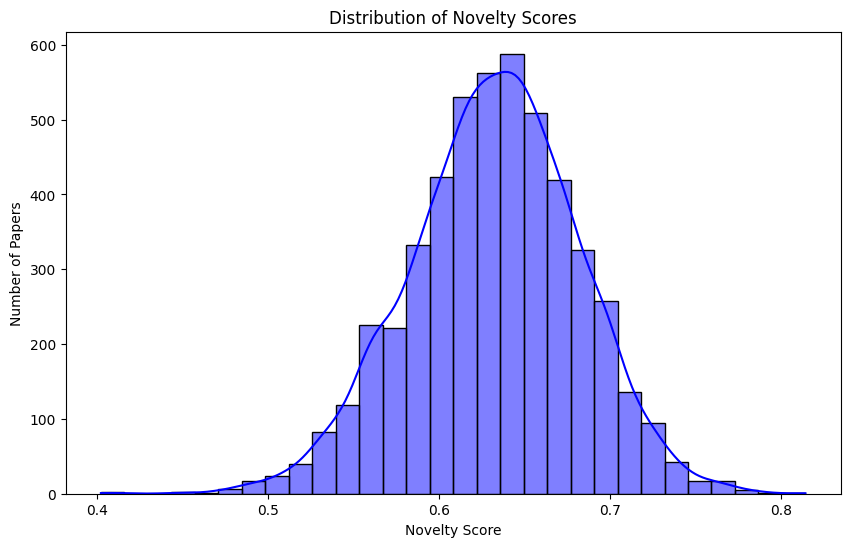

Top 5 Most Novel Papers:
                                                     title  novelty_score
1541669  Tissue Engineering of Skin Regeneration and Ha...       0.814125
2176006  Experimental Demonstration of End-to-End Optim...       0.791581
1509682  Overview of the global semiconductor industry ...       0.783224
2012927  Real-Time FPGA Demonstrator of ANN-Based Equal...       0.783108
1736048  On the positivity of a certain function relate...       0.779938

Bottom 5 Least Novel Papers:
                                                     title  novelty_score
1470603  A smooth complex rational affine surface with ...       0.402343
1756671  Left-invariant Ricci collineations associated ...       0.414158
2031992  Origin of the correlation between stellar kine...       0.447025
1966207  Resonant leptogenesis in minimal inverse seesa...       0.451360
2003896  Intermediate inflation in generalized non-mini...       0.467679


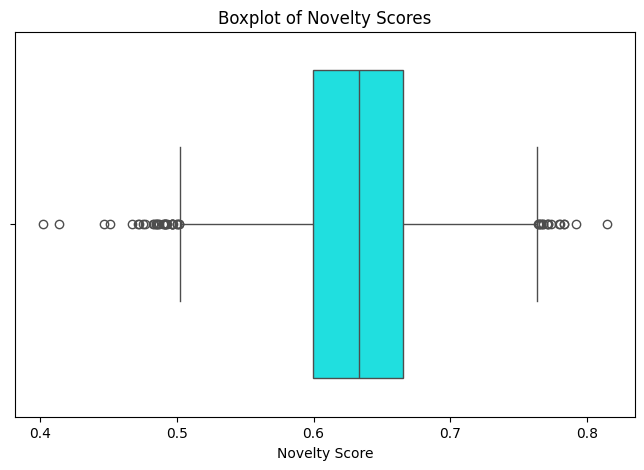

In [20]:
# Visualization
plt.figure(figsize=(10, 6))
sns.histplot(new_docs_df['novelty_score'], bins=30, kde=True, color='blue')
plt.xlabel("Novelty Score")
plt.ylabel("Number of Papers")
plt.title("Distribution of Novelty Scores")
plt.show()

# Top and bottom 5 papers by novelty
top_novel_papers = new_docs_df.nlargest(5, 'novelty_score')
low_novel_papers = new_docs_df.nsmallest(5, 'novelty_score')

print("Top 5 Most Novel Papers:")
print(top_novel_papers[['title', 'novelty_score']])
print("\nBottom 5 Least Novel Papers:")
print(low_novel_papers[['title', 'novelty_score']])

# Boxplot visualization
plt.figure(figsize=(8, 5))
sns.boxplot(x=new_docs_df['novelty_score'], color='cyan')
plt.title("Boxplot of Novelty Scores")
plt.xlabel("Novelty Score")
plt.show()